In [1]:
# Select gmm model using BIC criterion
# Use sklearn gmm implementation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from clean_data import *

In [2]:
# Prepare data for person 4. Use sequence 1~3 for training, 4~5 for testing.
person = 4
sadl_n = []
for n in range(1, 6):
    sadl_n.append(pd.read_table('data/S%d-ADL%d.dat' % (person, n), sep='\s+', header=None, dtype=float))

In [3]:
# Smooth data, time: col 0, features: col 1~36, labels: col 244 
winsize = 15
stepsize = 8

# train data
train_sample = np.empty((0, 36))
train_labels = np.empty((0))
train_len = []
for i in range(0, 3):
    features = moving_avg(sadl_n[i].iloc[:, 1:37], winsize, stepsize)
    labels = moving_vote_majority(sadl_n[i].iloc[:, 244], winsize, stepsize)
    train_sample = np.concatenate((train_sample, features), axis=0)
    train_len.append(features.shape[0])
    train_labels = np.concatenate( (train_labels, labels) )
train_len = np.array(train_len)

print "train_sample size: ", train_sample.shape
print "train_labels size: ", train_labels.shape
print "subsequence length: ", train_len, ". Sum of length: ", np.sum(train_len)

# test data
test_sample = np.empty((0, 36))
test_labels = np.empty((0))
test_len = []
for i in range(3, 5):
    features = moving_avg(sadl_n[i].iloc[:, 1:37], winsize, stepsize)
    labels = moving_vote_majority(sadl_n[i].iloc[:, 244], winsize, stepsize)
    test_sample = np.concatenate((test_sample, features), axis=0)
    test_len.append(features.shape[0])
    test_labels = np.concatenate( (test_labels, labels) )
test_len = np.array(test_len)  

print "test_sample size: ", test_sample.shape
print "test_labels size: ", test_labels.shape
print "subsequence length: ", test_len, ". Sum of length: ", np.sum(test_len)

train_sample size:  (11806, 36)
train_labels size:  (11806,)
subsequence length:  [5198 3467 3141] . Sum of length:  11806
test_sample size:  (6593, 36)
test_labels size:  (6593,)
subsequence length:  [2778 3815] . Sum of length:  6593


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:598: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [4]:
# Fill missing values
col_threshold = 0.5
train, test = fill_missing(train_sample, test_sample, col_threshold, True)

## Select model using BIC criterion

In [34]:
from sklearn.model_selection import KFold
from sklearn import mixture
def search_num_mixtures_bic(features, n_mix, plot_title):
    # return: 
    # gmm: the gmm model that gives the highest mean logprob
    # N: number of gaussian mixtures in the gmm
    # aic_best: aic of all data given the chosen number of components
    # bic_best: bic for all data given the chosen number of components
    bic_scores = [0 for i in range(0, len(n_mix))] # bic for each N
    aic_scores = [0 for i in range(0, len(n_mix))] # aic for each N

    for i, N in enumerate(n_mix):
        gmm = mixture.GaussianMixture(n_components=N, covariance_type='full', random_state=0)
        gmm.fit(features)
        bic_scores[i] = gmm.bic(features)
        aic_scores[i] = gmm.aic(features)
    
    plt.plot(n_mix, bic_scores, label="BIC")
    plt.plot(n_mix, aic_scores, label="AIC")
    plt.xlabel("number of components")
    plt.title(plot_title)
    plt.legend(loc='best')
    plt.show()
    
    i_gmm = np.argmin(bic_scores) # replace: find the elbows
    # Refit gmm using all data with selected number of mixtures
    n_opt = n_mix[i_gmm]
    gmm_opt = mixture.GaussianMixture(n_components=n_opt, covariance_type='full', random_state=0)
    gmm_opt.fit(features)
    
    return gmm_opt, n_opt, gmm_opt.bic(features), gmm_opt.aic(features)

def make_outputdistr_bic(train, train_labels, class2label):
    outputdistr_stats = pd.DataFrame(index=class2label, columns=['n_mixture', 'bic', 'aic'])
    outputdistr_gmm = []
    n_mix = range(1, 7)
    for i, label in enumerate(class2label):
        gmm, N, bic_score, aic_score = search_num_mixtures_bic(train[train_labels == label, :], n_mix, "label: " + str(label))
        outputdistr_gmm.append(gmm)
        outputdistr_stats.iloc[i, :] = [N, bic_score, aic_score]
    return outputdistr_gmm, outputdistr_stats

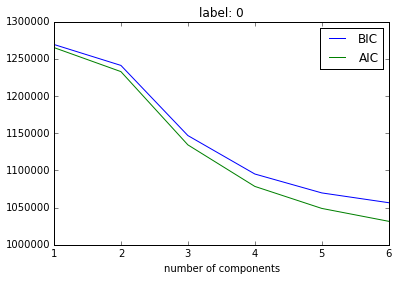

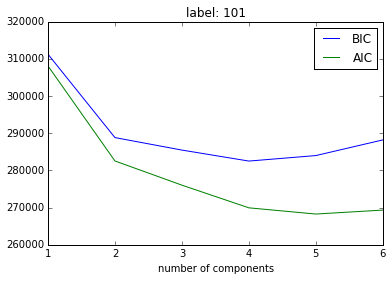

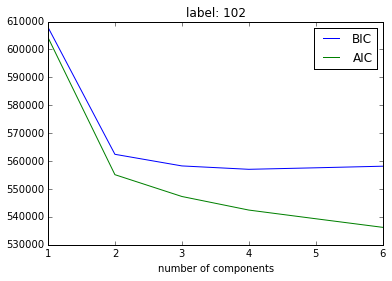

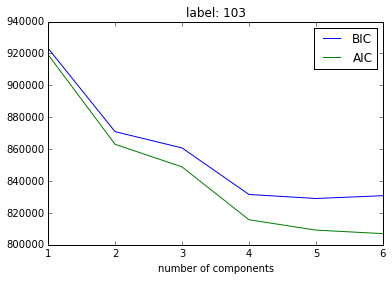

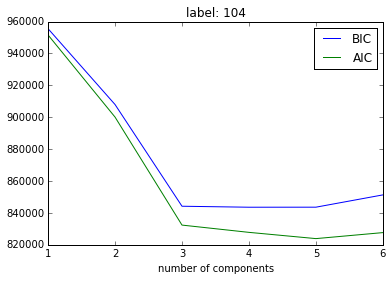

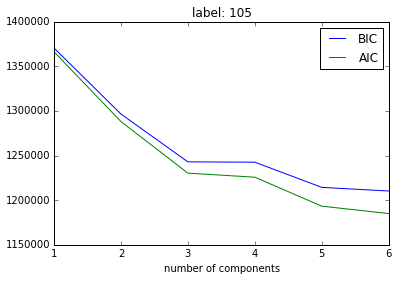

,n_mixture,bic,aic
0,6,1056581,1031569
101,4,282509.6,269937.9
102,4,557056.2,542448.3
103,5,829042.7,809218.3
104,4,843571.2,827801.9
105,6,1210251,1185007


In [35]:
gmms_bic, bic_stats = make_outputdistr_bic(train, train_labels, [0, 101, 102, 103, 104, 105])
bic_stats

## Select model using likelihood (cross validation)

In [37]:
def search_num_mixtures_likelihood(features, n_mix, n_folds):
    # return: 
    # gmm: the gmm model that gives the highest mean logprob
    # N: number of gaussian mixtures in the gmm
    # logp_x: mean of logP(Xt | gmm) for the chosen gmm
    mean_logprob = [0 for i in range(0, len(n_mix))] # mean of logP(Xt | gmm)

    for i, N in enumerate(n_mix):
        # K-fold cross validataion
        kf = KFold(n_splits = n_folds, random_state=0)
        likelihood_scores = []
        for train, val in kf.split(features):
            gmm = mixture.GaussianMixture(n_components=N, covariance_type='full', random_state=0)
            gmm.fit(features[train, :])
            likelihood_scores.append(gmm.score(features[val, :]))    
        mean_logprob[i] = np.mean(likelihood_scores)
    # Refit gmm using all data with selected number of mixtures

    i_gmm = np.argmax(mean_logprob)
    n_opt = n_mix[i_gmm]
    gmm_opt = mixture.GaussianMixture(n_components=n_opt, covariance_type='full', random_state=0)
    gmm_opt.fit(features)
    likelihood_score = gmm_opt.score(features)
    
    return gmm_opt, n_opt, likelihood_score

def make_outputdistr_likelihood(train, train_labels, class2label, n_folds):
    outputdistr_stats = pd.DataFrame(index=class2label, columns=['n_mixture', 'mean_logprob'])
    outputdistr_gmm = []
    n_mix = range(1, 7)
    for i, label in enumerate(class2label):
        gmm, N, logprob = search_num_mixtures_likelihood(train[train_labels == label, :], n_mix, n_folds)
        outputdistr_gmm.append(gmm)
        outputdistr_stats.iloc[i, :] = [N, logprob]
    return outputdistr_gmm, outputdistr_stats

In [38]:
gmms_ll, ll_stats = make_outputdistr_likelihood(train, train_labels, [0, 101, 102, 103, 104, 105], 4)
ll_stats

,n_mixture,mean_logprob
0,1,-227.0352
101,2,-216.174
102,2,-206.8629
103,1,-220.3269
104,1,-235.4301
105,2,-218.5875


In [26]:
# Evalute gmm on test data using naive bayes classifier
# max over label: P(label | X_t) = P(label, Xt) / P(X_t) ~ P(Xt | label) * P(label)

def naive_bayes_gmm_predict(val, gmms, priors, class2label):
    # Input
    # gmms: list of gmm distributions
    # priors: [n_states, ] prior probabilities
    # Returns:
    # labels
    n_samples = val.shape[0]
    logp_x_given_label = np.zeros((len(gmms), n_samples))
    for i, gmm in enumerate(gmms):
        logp_x_given_label[i, :] = gmm.score_samples(val)
    logp0 = np.tile(np.log(priors)[:, np.newaxis], (1, n_samples))
    logp_posterior = logp_x_given_label + logp0
    i_map = np.argmax(logp_posterior, axis=0)
    return [class2label[i] for i in i_map]

def compute_priors(train_labels, class2label):
    return [np.sum(train_labels == class2label[i]) / float(len(train_labels)) for i in range(0, len(class2label))]

In [36]:
class2label = [0, 101, 102, 103, 104, 105]
priors = compute_priors(train_labels, class2label)
print "priors: ", priors
train_label_pred = naive_bayes_gmm_predict(train, gmms_bic, np.ones((len(gmms_bic))), class2label)
print "Using bic criterion: accuracy on train data: ", np.sum(train_labels == train_label_pred) / float(len(train_label_pred))

test_label_pred = naive_bayes_gmm_predict(test, gmms_bic, np.ones((len(gmms_bic))), class2label)
print "Using bic criterion: accuracy on test data: ", np.sum(test_labels == test_label_pred) / float(len(test_label_pred))

priors:  [0.23572759613755717, 0.054802642724038626, 0.1130780958834491, 0.17643571065559885, 0.17093003557513128, 0.24902591902422497]
Using bic criterion: accuracy on train data:  0.905217685922
Using bic criterion: accuracy on test data:  0.385560442894


In [39]:
train_label_pred = naive_bayes_gmm_predict(train, gmms_ll, np.ones((len(gmms_ll))), class2label)
print "Using likelihood criterion: accuracy on train data: ", np.sum(train_labels == train_label_pred) / float(len(train_label_pred))

test_label_pred = naive_bayes_gmm_predict(test, gmms_ll, np.ones((len(gmms_ll))), class2label)
print "Using likelihood criterion: accuracy on test data: ", np.sum(test_labels == test_label_pred) / float(len(test_label_pred))

Using likelihood criterion: accuracy on train data:  0.68202608843
Using likelihood criterion: accuracy on test data:  0.476262702867
